### Deep Deterministic Policy Gradient (DDPG) Agent

Deep Deterministic Policy Gradient (DDPG) is a reinforcement learning algorithm that uses actor-critic methods (as seen in A2C); however, DDPG builds on the actor-critic framework by combining actor-critic methods with strategies from Q-learning (like DQN). Here, the `Critic` models the action-value function $Q_{\theta}(s,a)$ (instead of $V(s_t)$ from A2C). The algorithm also incorporates several features from DQN including the use of a `ReplayBuffer` for experience replay and the use of soft updates and target networks for both the `Actor` and the `Critic`.

In practice, Ornstein-Uhlenbeck noise `OUNoise` is often used to encourage exploration in DDPG. Ornstein-Uhlenbeck noise is a stochastic process that generates noise with specific characteristics: 1) Mean Reversion: The characteristic that the noise reverts to a central value over time (preventing noise from drifting too far) and 2) Temporal Correlation: The characteristic that noise values are correlated over time (encouraging smooth transitions rather than abrupt changes).

The Ornstein-Uhlenbeck process is mathematically defined by the following stochastic differential equation:

$$
d\mathbf{x}_t = \theta (\mu - \mathbf{x}_t) \, dt + \sigma \, d\mathbf{W}_t
$$

Where

$\theta (\mu - \mathbf{x}_t)$ is the mean reversion term that ensures that the noise $\mathbf{x}_t$ reverts to the mean $\mu$.

And

$\sigma \, d\mathbf{W}_t$ is the randomness term that introduces randomness from a normal distribution scaled by $\sigma$.

In the following implementation, this is seen in `OUNoise`:

```python

class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.2, sigma=0.3):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

```

**Further Enhancements To Implementation: Twin Deep Deterministic Policy Gradient (TD3)**

DDPG can suffer from overestimation bias in the critic network (similar to issues seen in DQN). TD3 addresses this issue by using two separate critic networks and updating the policy using the minimum value from both critics, reducing the risk of overestimation (similar approach to Double DQN). Furthermore, TD3 introduces policy smoothing where small noise is added to target actions to prevent the critic from becoming overly optimistic about specific actions. Additionally, TD3 introduces delayed policy updates where the `Actor` is updated less frequently than the `Critic`, allowing the action-value estimates to stabilize before updating the policy.

---

The full implementation is below

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=400, n_hidden_2_dim=300):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

class QNetwork(nn.Module):
    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=400, n_hidden_2_dim=300):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim + n_action_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [2]:
from collections import deque
import numpy as np
import random

class ReplayBuffer:
    def __init__(self, buffer_size: int, batch_size: int):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def store(self, experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
        self.memory.append(experience)

    def sample(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        experiences = random.sample(self.memory, k=self.batch_size)

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

In [3]:
import numpy as np

class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.2, sigma=0.5):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma

        self.action_dim = action_dim
        
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state


In [4]:
import torch.optim as optim

class Agent:
    def __init__(self, obs_dim, act_dim, act_limit, alpha=5e-4, gamma=0.99, tau=0.01, delay=5, policy_noise=0.2, noise_clip=0.3, buffer_size=100000, batch_size=128):
        
        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

        self.delay = delay
        self.count = 0

        self.act_limit = act_limit 

        self.policy_noise = policy_noise
        self.noise_clip = noise_clip

        self.actor = PolicyNetwork(obs_dim, act_dim)
        self.critic_1 = QNetwork(obs_dim, act_dim)
        self.critic_2 = QNetwork(obs_dim, act_dim)

        self.actor_target = PolicyNetwork(obs_dim, act_dim)
        self.critic_1_target = QNetwork(obs_dim, act_dim)
        self.critic_2_target = QNetwork(obs_dim, act_dim)

        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())

        self.actor_optimizer = optim.AdamW(self.actor.parameters(), lr=self.alpha)
        self.critic_1_optimizer = optim.AdamW(self.critic_1.parameters(), lr=self.alpha)
        self.critic_2_optimizer = optim.AdamW(self.critic_2.parameters(), lr=self.alpha)

        self.memory = ReplayBuffer(buffer_size, batch_size)

        self.noise = OUNoise(act_dim)

        self.eps = np.finfo(np.float32).eps.item()

    def act(self, state, noise_scale):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        action = self.actor(state).detach().numpy()[0]
        action += noise_scale * self.noise.sample()

        return np.clip(action, -self.act_limit, self.act_limit)

    def step(self, experience: tuple[np.ndarray, int, float, np.ndarray, bool]) -> None:
        self.memory.store(experience)

        if len(self.memory) >= 1000:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, dones = self.memory.sample()

        rewards = rewards.unsqueeze(1) 
        dones = dones.unsqueeze(1) 

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            noise = torch.clamp(torch.tensor(np.random.randn(*next_actions.shape), dtype=torch.float32) * self.policy_noise, -self.noise_clip, self.noise_clip)
            next_actions = torch.clamp(next_actions + noise, -self.act_limit, self.act_limit)

            Q1_targets_next = self.critic_1_target(next_states, next_actions)
            Q2_targets_next = self.critic_2_target(next_states, next_actions)
            Q_targets = rewards + (1 - dones) * self.gamma * torch.min(Q1_targets_next, Q2_targets_next)

        Q1_predicted = self.critic_1(states, actions)
        Q2_predicted = self.critic_2(states, actions)

        critic_1_loss = (F.mse_loss(Q1_predicted, Q_targets, reduction='none')).mean()
        critic_2_loss = (F.mse_loss(Q2_predicted, Q_targets, reduction='none')).mean()

        actor_loss = -(self.critic_1(states, self.actor(states))).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        self.count += 1
        if self.count% self.delay == 0:
            self.soft_update(self.actor, self.actor_target)
            self.soft_update(self.critic_1, self.critic_1_target)
            self.soft_update(self.critic_2, self.critic_2_target)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


In [5]:
import gymnasium as gym

env = gym.make('BipedalWalker-v3', render_mode='rgb_array')

obs_space = env.observation_space.shape[0]
act_space = env.action_space.shape[0]
act_limit = env.action_space.high[0]

print(f"=== BipedalWalker-v3 Environment ===")
print(f" Observation Space:", obs_space)
print(f" Action Space:", act_space)

=== BipedalWalker-v3 Environment ===
 Observation Space: 24
 Action Space: 4


In [6]:
import imageio

agent = Agent(obs_space, act_space, act_limit)

n_average = 50
reward_hist = []
frames = []

noise_scale = 0.1

n_trajectories = 2000
for i in range(1, n_trajectories + 1):

    state = env.reset()[0]
    total_reward = 0

    T = 1000
    for t in range(T):

        if i % (n_average * 2) == 0:
            frame = env.render()
            frames.append(frame)

        action = agent.act(state, noise_scale)

        next_state, reward, terminated, truncated, _ = env.step(action) 
        done = terminated or truncated
        agent.step((state, action, reward, next_state, done))
        total_reward += reward
        state = next_state

        if done:
            break
    
    reward_hist.append(total_reward)

    noise_scale *= 0.99

    if i % n_average == 0:
        avg_reward = np.mean(reward_hist[-n_average:])
        print(f'Episode {i}/{n_trajectories} | Average Reward: {avg_reward:.2f}')

Episode 50/2000 | Average Reward: -103.38
Episode 100/2000 | Average Reward: -102.83
Episode 150/2000 | Average Reward: -102.22
Episode 200/2000 | Average Reward: -102.24
Episode 250/2000 | Average Reward: -100.39
Episode 300/2000 | Average Reward: -105.66
Episode 350/2000 | Average Reward: -99.79
Episode 400/2000 | Average Reward: -107.22
Episode 450/2000 | Average Reward: -112.31
Episode 500/2000 | Average Reward: -118.97
Episode 550/2000 | Average Reward: -113.19
Episode 600/2000 | Average Reward: -114.69
Episode 650/2000 | Average Reward: -114.38
Episode 700/2000 | Average Reward: -115.08
Episode 750/2000 | Average Reward: -108.80
Episode 800/2000 | Average Reward: -122.00
Episode 850/2000 | Average Reward: -116.38
Episode 900/2000 | Average Reward: -105.44
Episode 950/2000 | Average Reward: -93.34
Episode 1000/2000 | Average Reward: -110.64
Episode 1050/2000 | Average Reward: -115.00
Episode 1100/2000 | Average Reward: -112.22
Episode 1150/2000 | Average Reward: -111.88
Episode 12

In [7]:
torch.save(agent.actor_target.state_dict(), 'DDPG.pth')

In [8]:
imageio.mimsave('./GIF/DDPG.GIF', frames, fps=20)

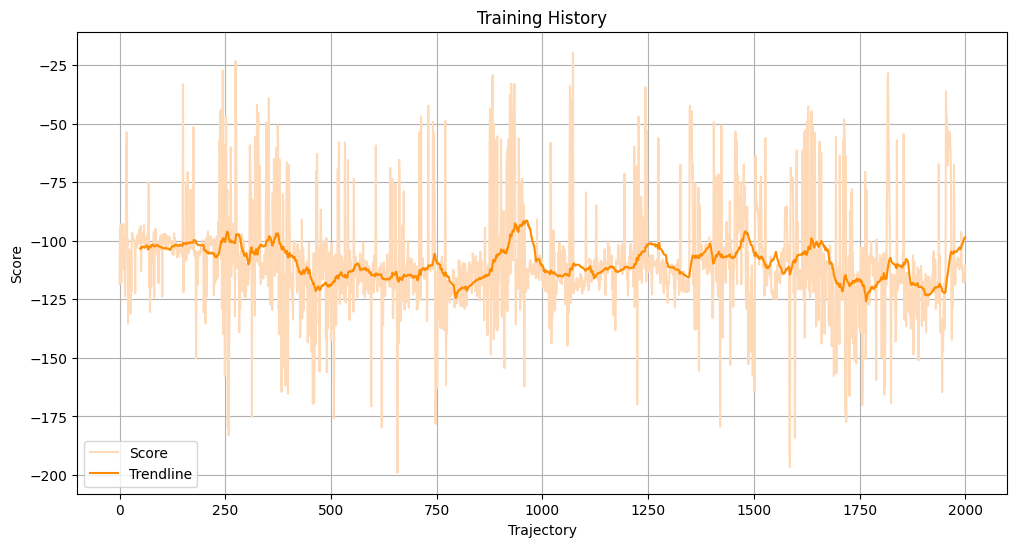

In [9]:
import matplotlib.pyplot as plt

trendline = np.convolve(reward_hist, np.ones(n_average)/n_average, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color='#FFDAB9')
plt.plot(range(n_average-1, len(reward_hist)), trendline, label='Trendline', color='#FF8C00')
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()